In [1]:
%matplotlib notebook
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas
import scipy.signal
from scipy.ndimage.filters import gaussian_filter,gaussian_filter1d
pandas.set_option('display.max_rows', 1000)

def bold(obj):
    return fr"$\bf{{{obj}}}$"

In [2]:
def combine_results(results_path):
    # Combine results
    combined_results_path = results_path + '/nsgaii_results_all.csv'
    with open(combined_results_path, 'w') as combined_results_file:
        combined_results_file.write('numMobiles\tpopulationSize\tmapoModelMaxEvaluations\tinjectedSolutionsFraction\tavg\tstd\tstd_percent\ttime\n')
    for res_filename in os.listdir(results_path):
        if res_filename.endswith('.csv') and res_filename not in combined_results_path:
            with open(os.path.join(results_path, res_filename), 'r') as partial_results_file, open(combined_results_path, 'a') as combined_results_file:
                combined_results_file.writelines(partial_results_file.readlines())
                
    return combined_results_path

<IPython.core.display.Javascript object>


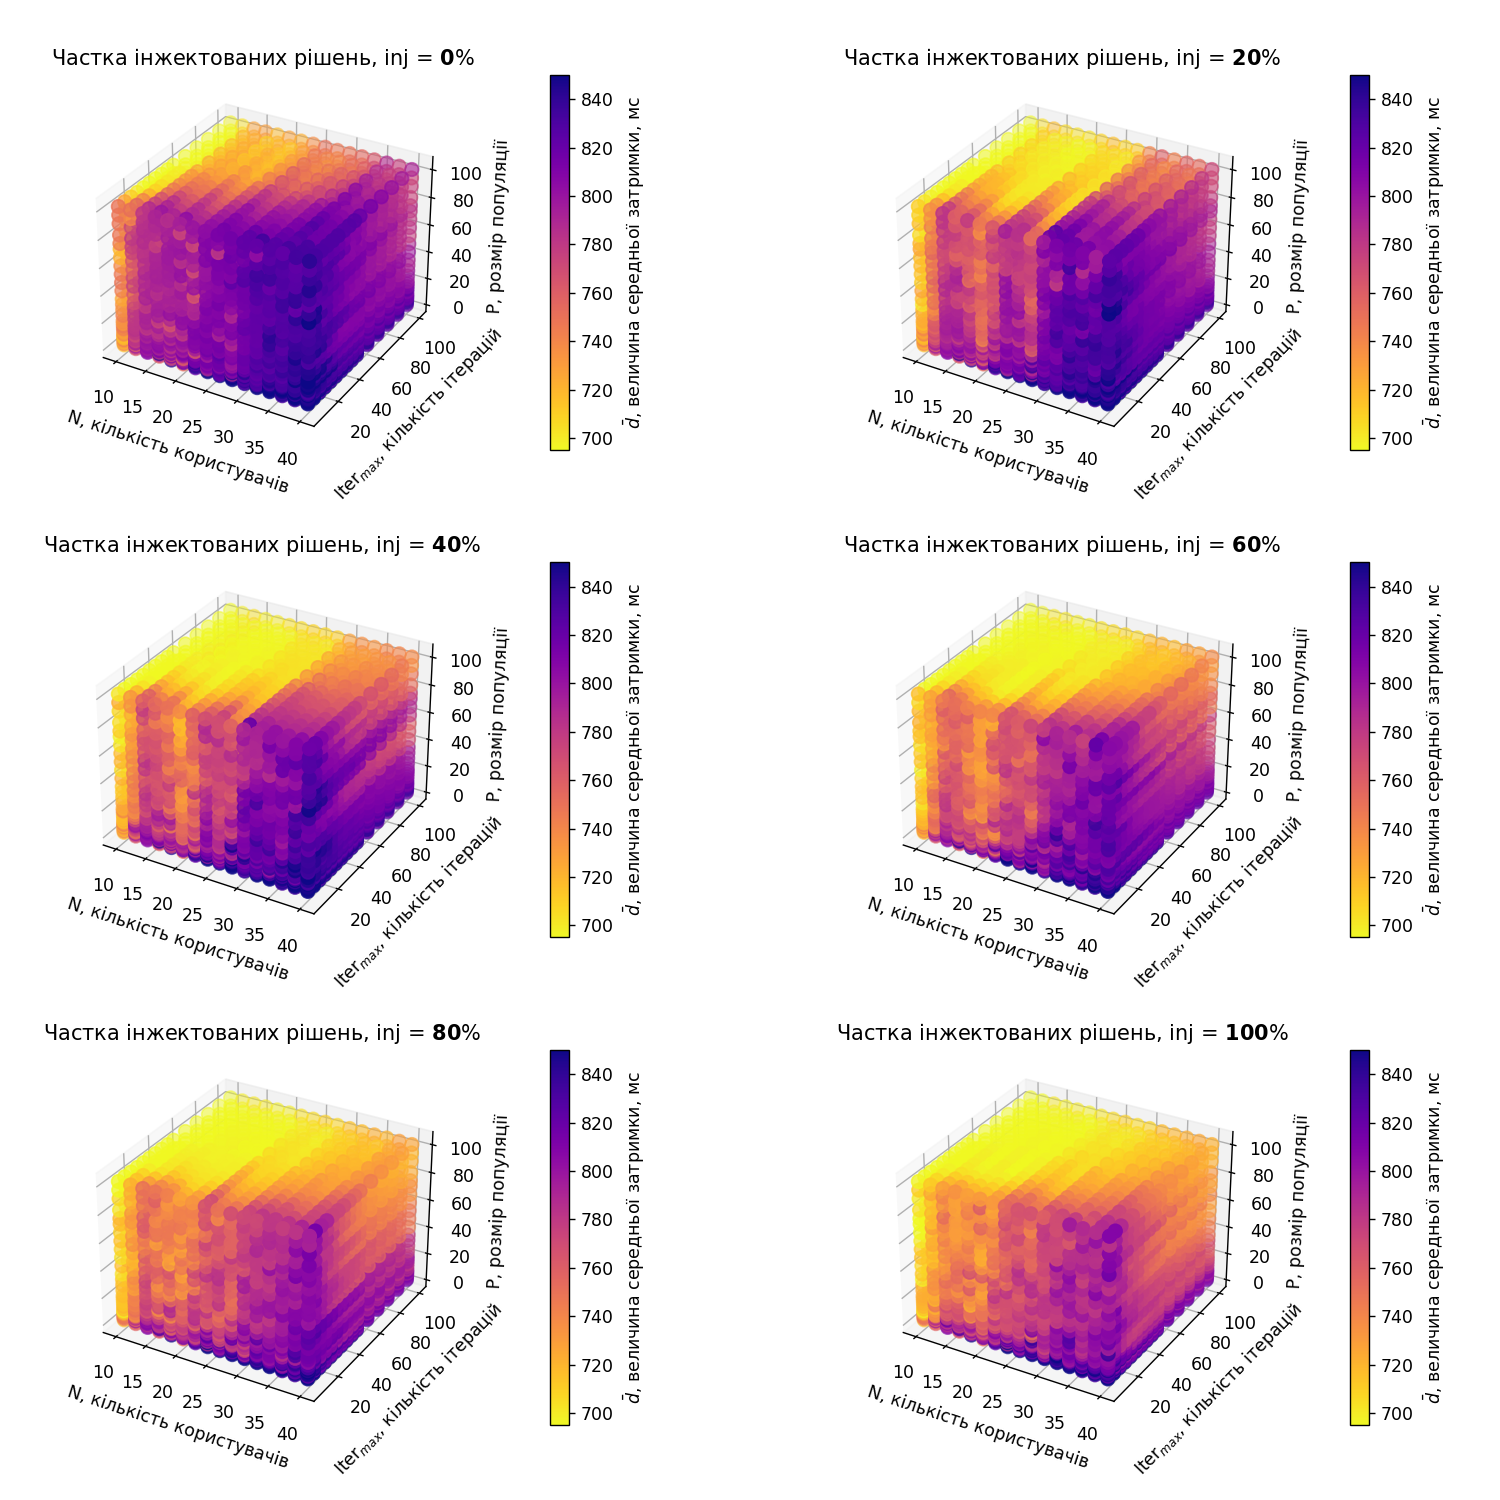

In [15]:
df = pandas.read_csv(combine_results('results/experiment2_1'),'', delimiter='\t', decimal=',')
df = df.sort_values(['injectedSolutionsFraction', 'numMobiles', 'mapoModelMaxEvaluations', 'populationSize'])
df = df.drop_duplicates(['numMobiles','populationSize','mapoModelMaxEvaluations','injectedSolutionsFraction'])

group_filter = [0, 20, 40, 60, 80, 100]
x_name = 'numMobiles'
y_name = 'mapoModelMaxEvaluations'
z_name = 'populationSize'
period_y = df.groupby(['injectedSolutionsFraction', 'numMobiles', 'mapoModelMaxEvaluations']).count()['avg'].max()
fig = plt.figure(figsize=(6*len(group_filter)//3, 4 * len(group_filter)//2))
count = 1
for inject_val, sub_df in df.groupby('injectedSolutionsFraction'):
    if inject_val in group_filter:
        x = sub_df[x_name].to_numpy().reshape(-1, period_y)
        y = sub_df[y_name].to_numpy().reshape(-1, period_y)
        z = sub_df[z_name].to_numpy().reshape(-1, period_y)
        c = sub_df['avg'].to_numpy().reshape(-1, period_y)
        c = gaussian_filter(c, sigma=0.5, mode='nearest')
        c = c.reshape(-1)
        ax = fig.add_subplot(len(group_filter) // 2,len(group_filter) // 3, count, projection='3d')
        vmax = None
        vmin = None
        vmax = 850#c.max()
        vmin = 695#c.min()
        img = ax.scatter(x, y, z, c=c, s=60, cmap=cm.get_cmap('plasma_r'), vmax=vmax, vmin=vmin)
        ax.set_xlabel('N, кількість користувачів')
        ax.set_ylabel('Iter$_{max}$, кількість ітерацій')
        ax.set_zlabel('P, розмір популяції')
        ax.set_title(f'Частка інжектованих рішень, inj = {bold(inject_val)}%')
        count += 1
        fig.colorbar(img, pad=0.1, label='$\\bar{d}$, величина середньої затримки, мс')
fig.subplots_adjust(left=-0.2, right=1, top=0.95, bottom=0.05, wspace=-0.2, hspace=0.3)

<IPython.core.display.Javascript object>


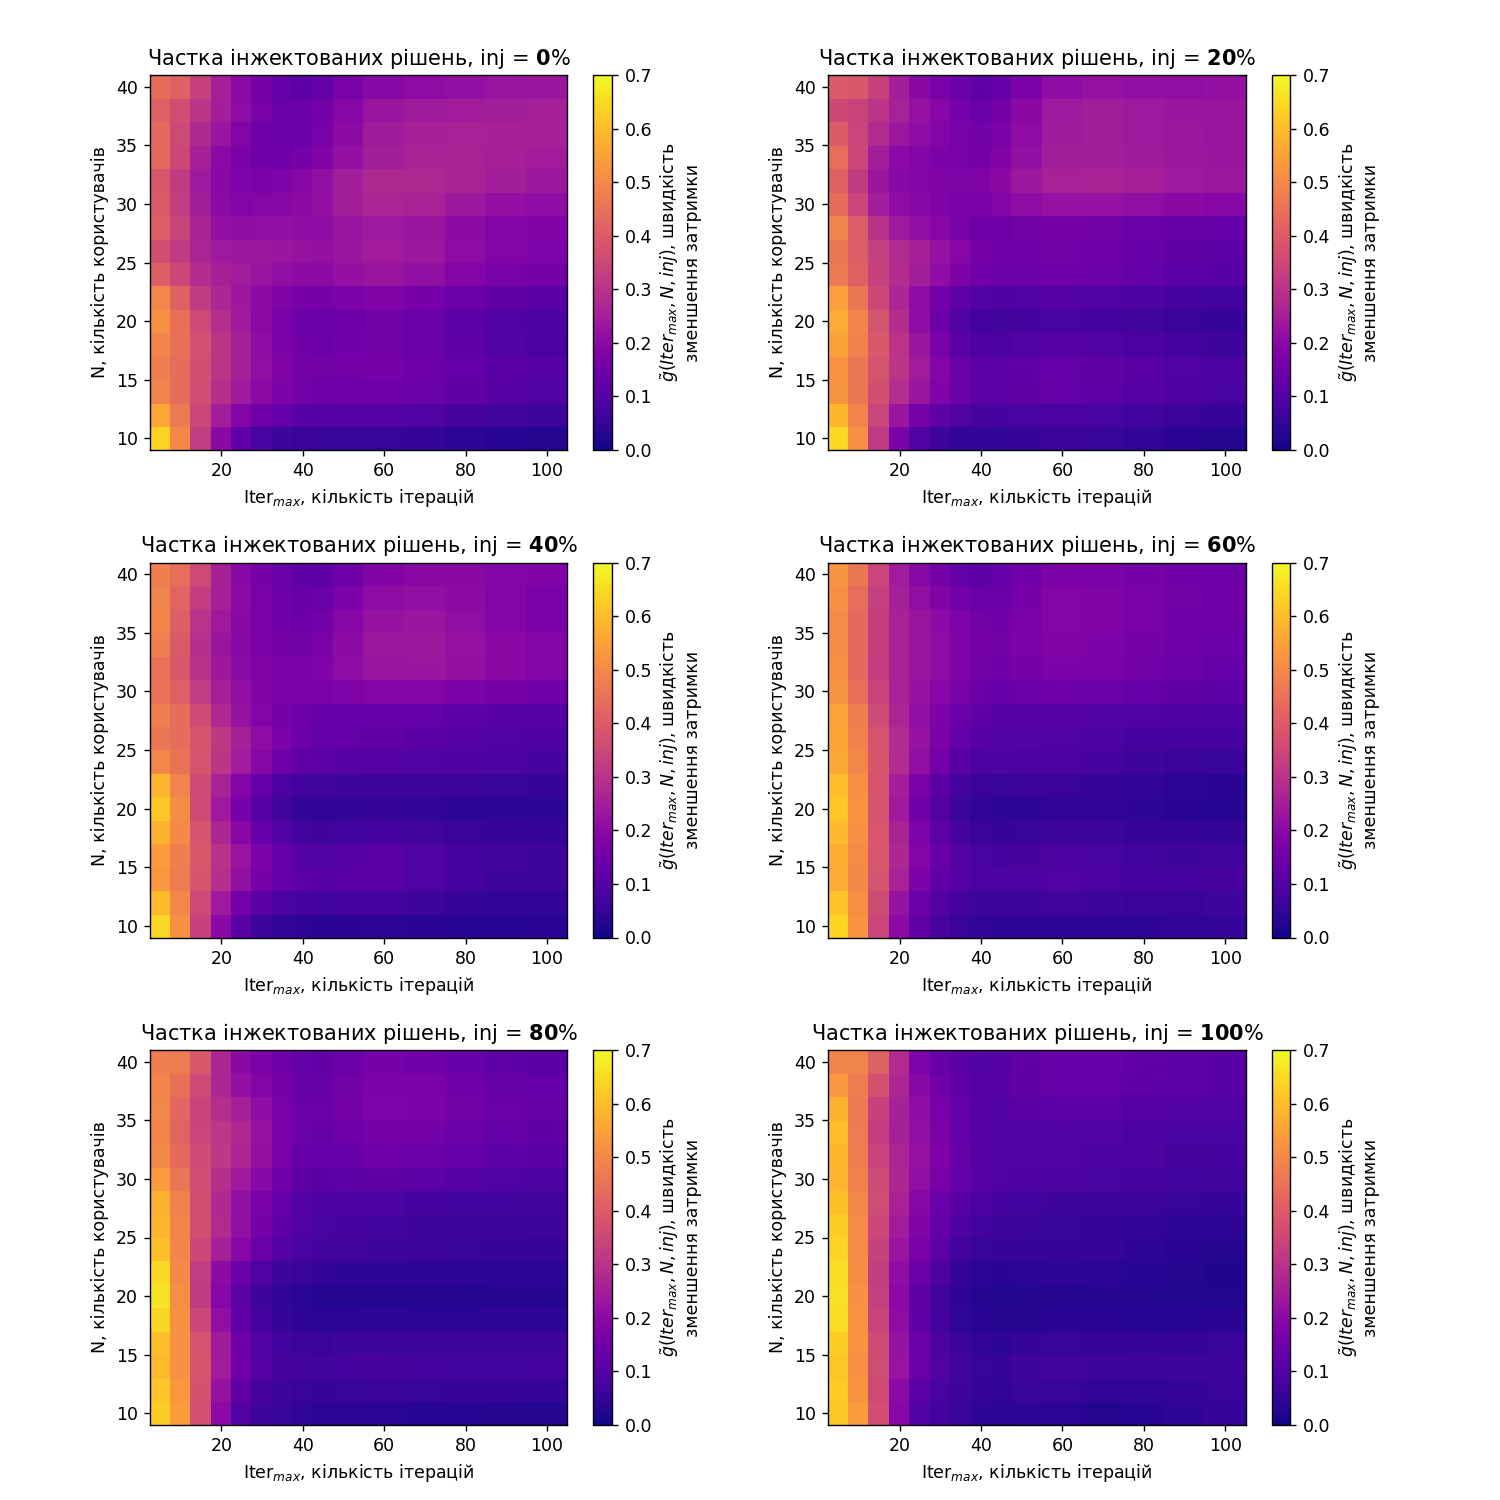

In [16]:
df = pandas.read_csv(combine_results('results/experiment2_1'),'', delimiter='\t', decimal=',')
# df['mapoModelMaxEvaluations'] /= df['populationSize']
df = df.sort_values(['mapoModelMaxEvaluations', 'numMobiles', 'populationSize'])
df = df.drop_duplicates(['numMobiles','populationSize','mapoModelMaxEvaluations','injectedSolutionsFraction'])

total_plots = len(df.groupby(['injectedSolutionsFraction']))
fig = plt.figure(figsize=(6 * total_plots // 3, 4 * total_plots // 2))

group_filter = [0, 20, 40, 60, 80, 100]
# df = df[df['populationSize'] == 6]
plot_count = 1
for inject_val, df_gr1 in df.groupby('injectedSolutionsFraction'):
    if inject_val in group_filter:
        corrs = []
        for num_mobiles, df_gr2 in df_gr1.groupby('numMobiles'):
            x_ = df_gr2['mapoModelMaxEvaluations'].drop_duplicates().to_numpy()
            y_ = df_gr2.groupby(['injectedSolutionsFraction', 'numMobiles', 'mapoModelMaxEvaluations']).agg('mean')['avg'].to_numpy()
            corrs.append(np.gradient(-y_))
#             corrs.append(y_)
        df_gr1 = df_gr1[['mapoModelMaxEvaluations', 'numMobiles']].drop_duplicates().reset_index()
        x = np.transpose(df_gr1['mapoModelMaxEvaluations'].to_numpy().reshape(-1, len(df_gr1.groupby('numMobiles'))))
        y = np.transpose(df_gr1['numMobiles'].to_numpy().reshape(-1, len(df_gr1.groupby('numMobiles'))))
        z = np.array(corrs)
        z /= np.sqrt((z ** 2).sum(axis=1)[:, np.newaxis])
        z = gaussian_filter(z, sigma=1.0)
    #     print(x, y, z)
    #     print(x.shape, y.shape, z.shape)
        vmin = None
        vmax = None
        vmin = 0
        vmax = 0.7
        ax = fig.add_subplot(total_plots // 2, total_plots // 3, plot_count)
        img = ax.pcolormesh(x, y, z, cmap=cm.get_cmap('plasma'), shading='nearest', vmin=vmin, vmax=vmax)
    #     print()
        ax.set_xlabel('Iter$_{max}$, кількість ітерацій')
        ax.set_ylabel('N, кількість користувачів')
        ax.set_title(f'Частка інжектованих рішень, inj = {bold(inject_val)}%')
        fig.colorbar(img, pad=0.05, label='$\\tilde{g}(Iter_{max},N,inj)$, швидкість\nзменшення затримки')
        plot_count += 1
fig.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.05, wspace=0.3, hspace=0.3)


<IPython.core.display.Javascript object>


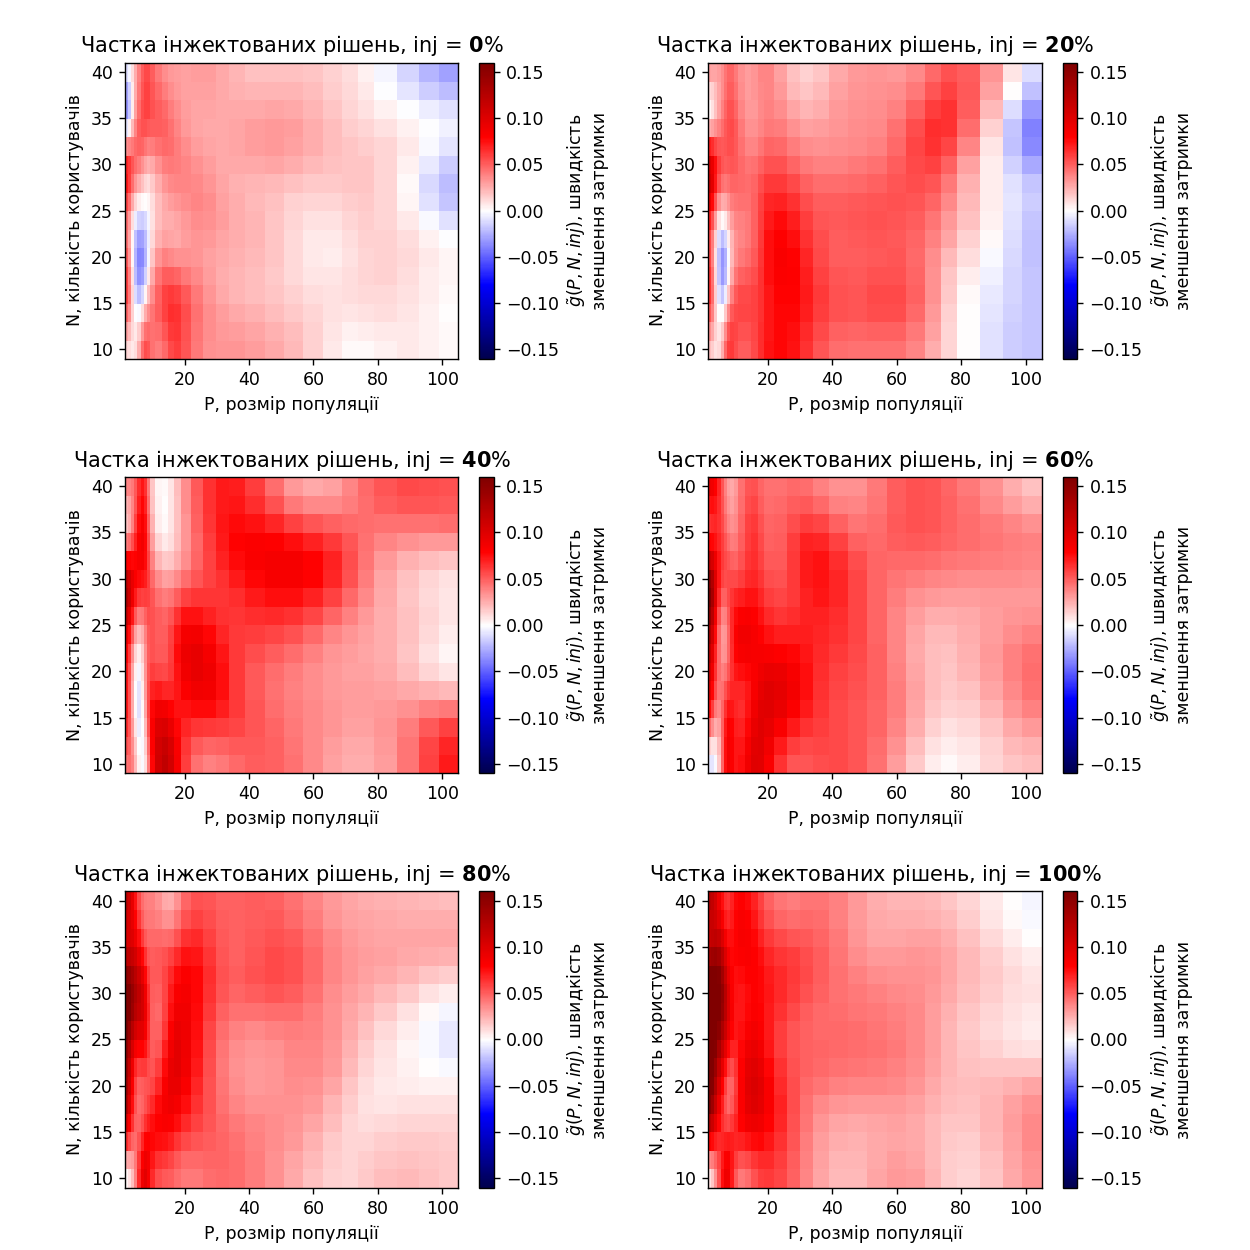

In [17]:
df = pandas.read_csv(combine_results('results/experiment2_1'),'', delimiter='\t', decimal=',')
# df['mapoModelMaxEvaluations'] /= df['populationSize]
df = df.sort_values(['populationSize', 'numMobiles', 'mapoModelMaxEvaluations'])
df = df.drop_duplicates(['numMobiles','populationSize','mapoModelMaxEvaluations','injectedSolutionsFraction'])

total_plots = len(df.groupby(['injectedSolutionsFraction']))
fig = plt.figure(figsize=(5 * total_plots // 3, 3.5 * total_plots // 2))

group_filter = [0, 20, 40, 60, 80, 100]
# df = df[df['populationSize'] == 6]
plot_count = 1
for inject_val, df_gr1 in df.groupby('injectedSolutionsFraction'):
    if inject_val in group_filter:
        corrs = []
        for num_mobiles, df_gr2 in df_gr1.groupby('numMobiles'):
            y_ = df_gr2.groupby(['injectedSolutionsFraction', 'numMobiles', 'populationSize']).agg('mean')['avg'].to_numpy()
            corrs.append(np.gradient(-y_))
#             corrs.append(y_)        
#             corrs.append(y_)
        df_gr1 = df_gr1[['populationSize', 'numMobiles']].drop_duplicates().reset_index()
        x = np.transpose(df_gr1['populationSize'].to_numpy().reshape(-1, len(df_gr1.groupby('numMobiles'))))
        y = np.transpose(df_gr1['numMobiles'].to_numpy().reshape(-1, len(df_gr1.groupby('numMobiles'))))
        z = np.array(corrs)
        z /= np.sqrt((z ** 2).sum(axis=1)[:, np.newaxis])
        z = gaussian_filter(z, sigma=2.0)
    #     print(x, y, z)
    #     print(x.shape, y.shape, z.shape)
        vmin = None
        vmax = None
        vmax = 0.16
        vmin = -vmax

#         vmin = -z.max()
#         vmax = z.max()
        ax = fig.add_subplot(total_plots // 2, total_plots // 3, plot_count)
        img = ax.pcolormesh(x, y, z, cmap=cm.get_cmap('seismic'), shading='nearest', vmin=vmin, vmax=vmax)
    #     print()
        ax.set_xlabel('P, розмір популяції')
        ax.set_ylabel('N, кількість користувачів')
        ax.set_title(f'Частка інжектованих рішень, inj = {bold(inject_val)}%')
        fig.colorbar(img, pad=0.05, label='$\\tilde{g}(P,N,inj)$, швидкість\nзменшення затримки')
        plot_count += 1
fig.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.05, wspace=0.4, hspace=0.4)

<IPython.core.display.Javascript object>


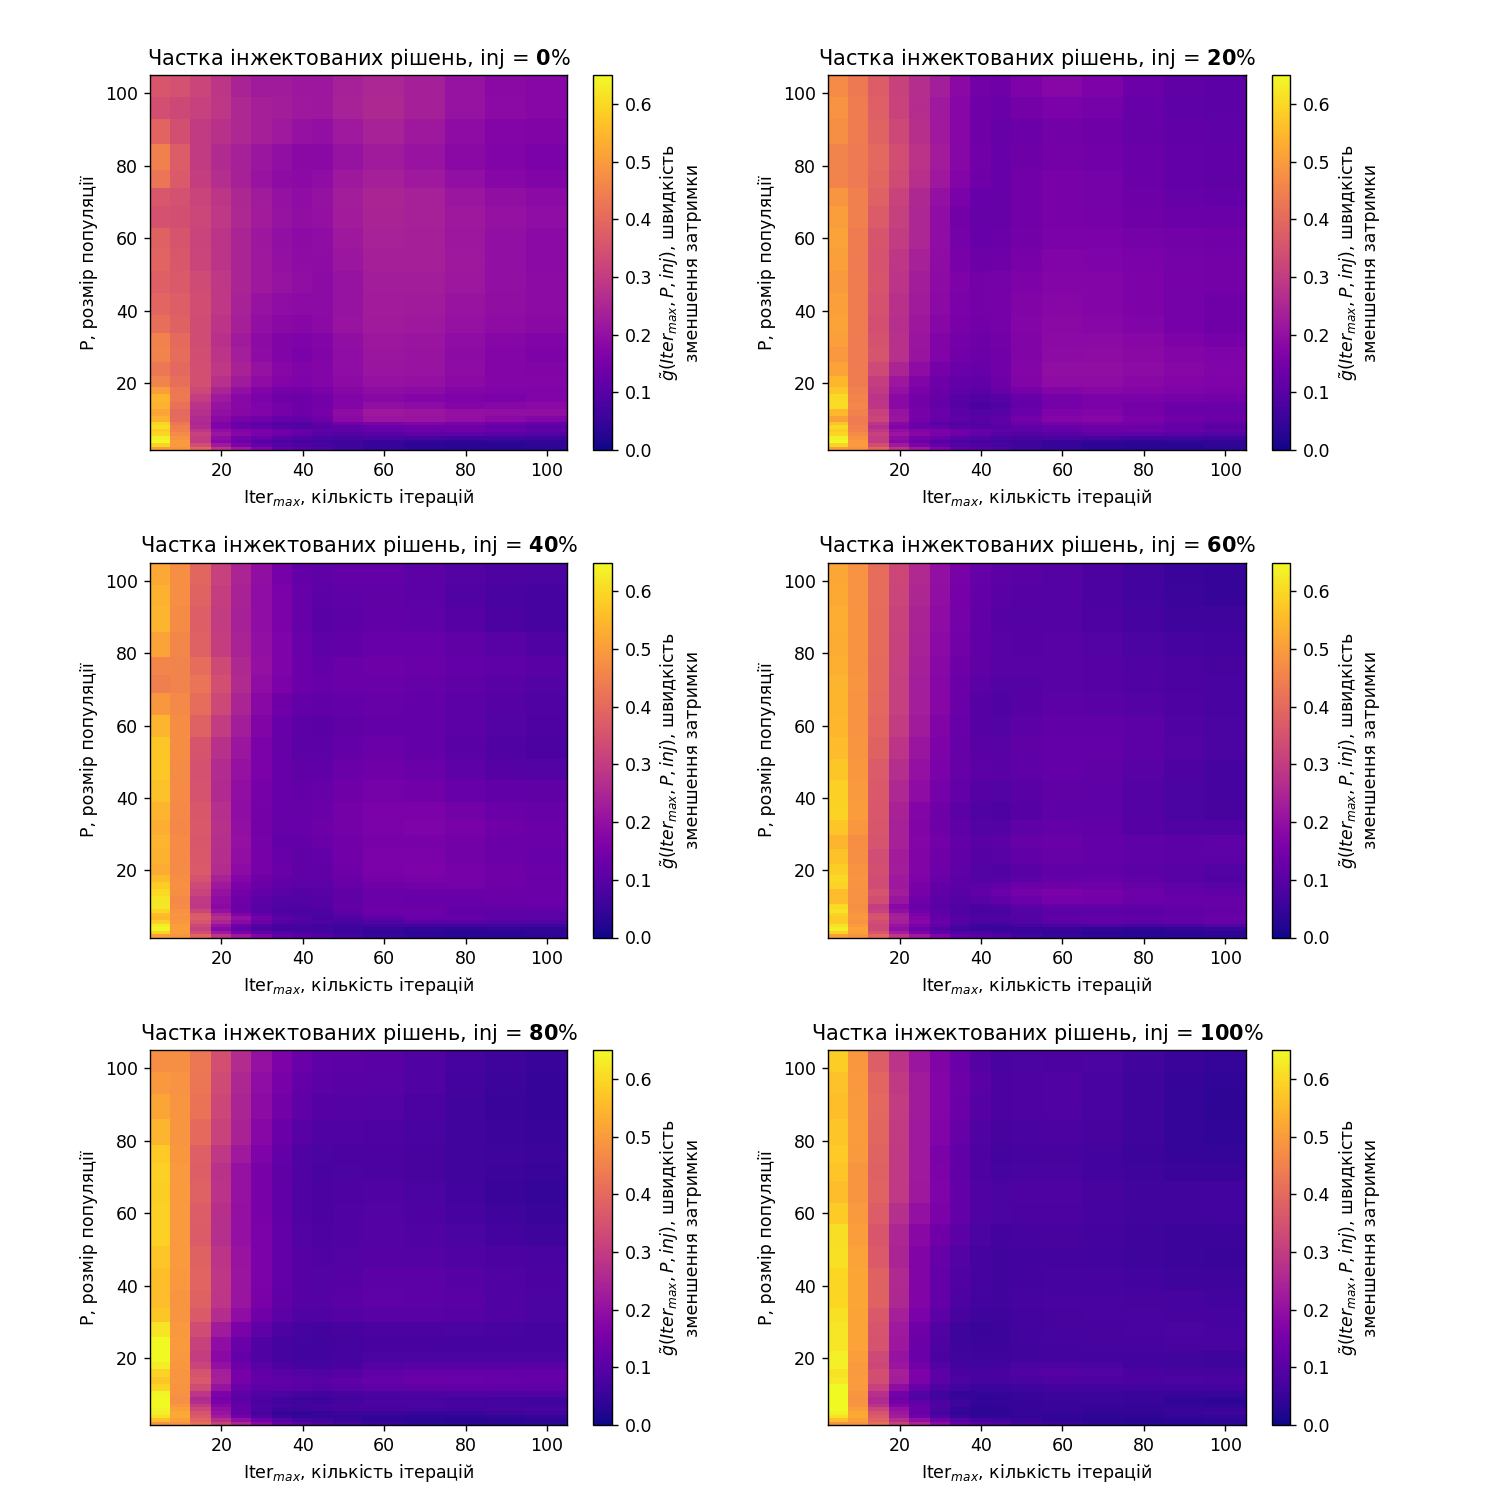

In [18]:
df = pandas.read_csv(combine_results('results/experiment2_1'),'', delimiter='\t', decimal=',')
# df['mapoModelMaxEvaluations'] /= df['populationSize]
df = df.sort_values(['mapoModelMaxEvaluations', 'populationSize', 'numMobiles'])
df = df.drop_duplicates(['numMobiles','populationSize','mapoModelMaxEvaluations','injectedSolutionsFraction'])

total_plots = len(df.groupby(['injectedSolutionsFraction']))
fig = plt.figure(figsize=(6 * total_plots // 3, 4 * total_plots // 2))

group_filter = [0, 20, 40, 60, 80, 100]
# df = df[df['populationSize'] == 6]
plot_count = 1
for inject_val, df_gr1 in df.groupby('injectedSolutionsFraction'):
    if inject_val in group_filter:
        corrs = []
        for num_mobiles, df_gr2 in df_gr1.groupby('populationSize'):
            y_ = df_gr2.groupby(['injectedSolutionsFraction', 'populationSize', 'mapoModelMaxEvaluations']).agg('mean')['avg'].to_numpy()
            corrs.append(np.gradient(-y_))
#             corrs.append(y_)        
#             corrs.append(y_)
        df_gr1 = df_gr1[['mapoModelMaxEvaluations', 'populationSize']].drop_duplicates().reset_index()
        x = np.transpose(df_gr1['mapoModelMaxEvaluations'].to_numpy().reshape(-1, len(df_gr1.groupby('populationSize'))))
        y = np.transpose(df_gr1['populationSize'].to_numpy().reshape(-1, len(df_gr1.groupby('populationSize'))))
        z = np.array(corrs)
        z /= np.sqrt((z ** 2).sum(axis=1)[:, np.newaxis])
        z = gaussian_filter(z, sigma=1.0)
    #     print(x, y, z)
        ax = fig.add_subplot(total_plots // 2, total_plots // 3, plot_count)
    #     print(x.shape, y.shape, z.shape)
        vmin = None
        vmax = None
        vmax = 0.65
        vmin = 0

#         vmin = -z.max()
#         vmax = z.max()
        img = ax.pcolormesh(x, y, z, cmap=cm.get_cmap('plasma'), shading='nearest', vmin=vmin, vmax=vmax)
    #     print()
        ax.set_xlabel('Iter$_{max}$, кількість ітерацій')
        ax.set_ylabel('P, розмір популяції')
        ax.set_title(f'Частка інжектованих рішень, inj = {bold(inject_val)}%')
        fig.colorbar(img, pad=0.05, label='$\\tilde{g}(Iter_{max},P,inj)$, швидкість\nзменшення затримки')
        plot_count += 1
fig.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.05, wspace=0.3, hspace=0.3)


<IPython.core.display.Javascript object>


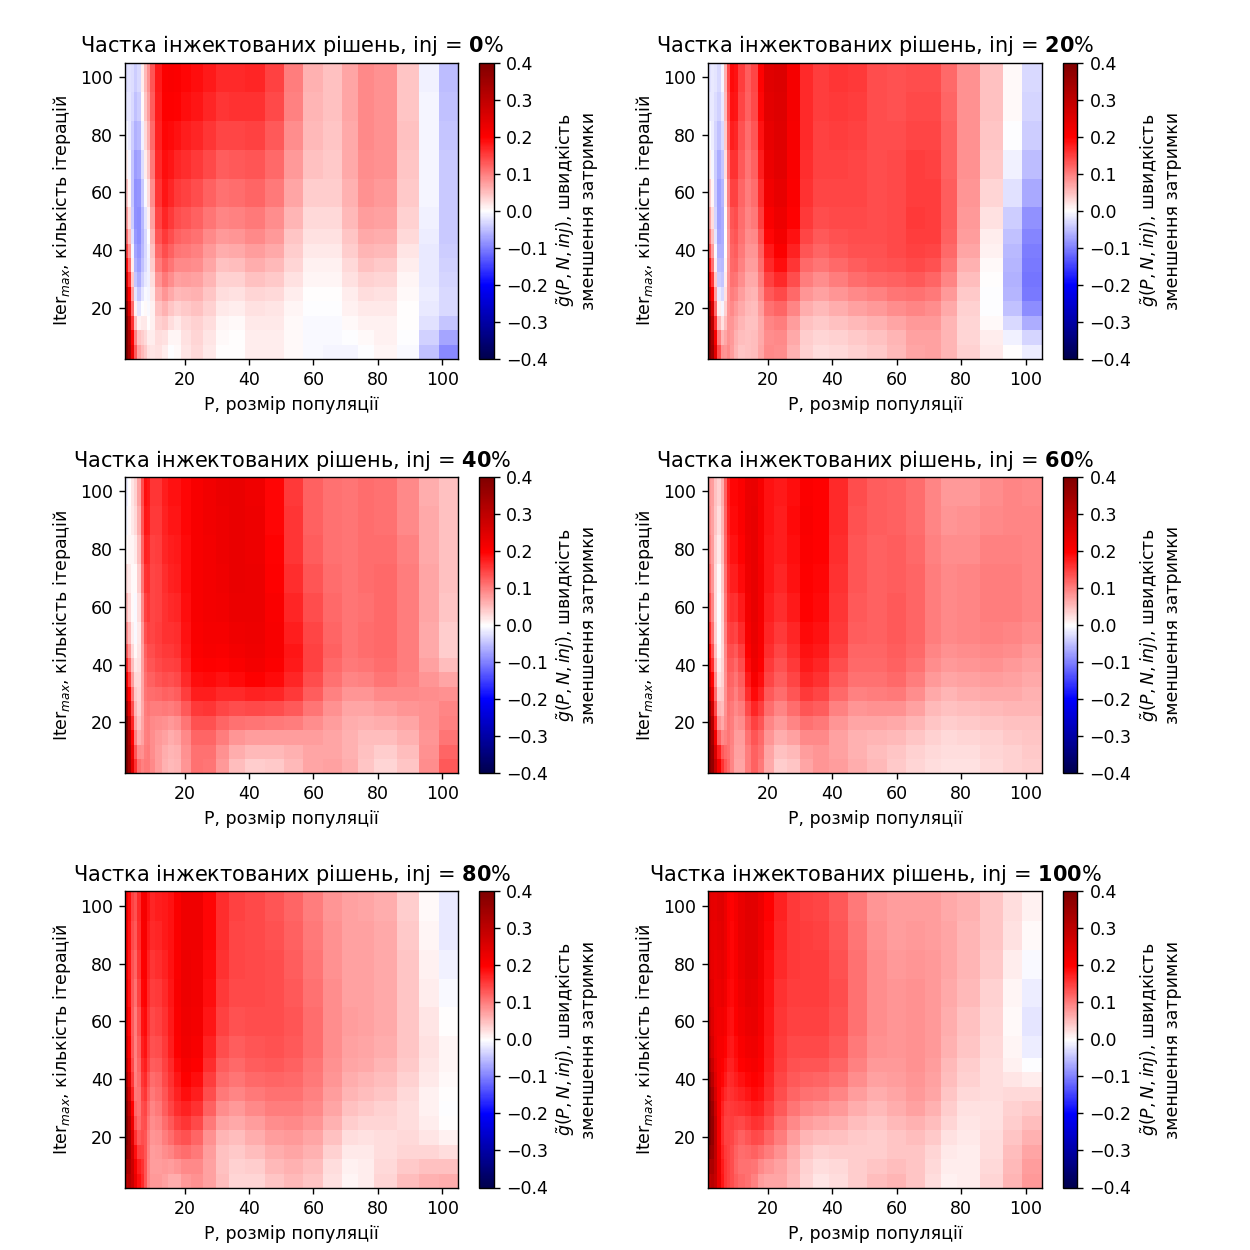

In [19]:
df = pandas.read_csv(combine_results('results/experiment2_1'),'', delimiter='\t', decimal=',')
# df['mapoModelMaxEvaluations'] /= df['populationSize]
df = df.sort_values(['populationSize', 'mapoModelMaxEvaluations', 'numMobiles'])
df = df.drop_duplicates(['numMobiles','populationSize','mapoModelMaxEvaluations','injectedSolutionsFraction'])

total_plots = len(df.groupby(['injectedSolutionsFraction']))
fig = plt.figure(figsize=(5 * total_plots // 3, 3.5 * total_plots // 2))

group_filter = [0, 20, 40, 60, 80, 100]
# df = df[df['populationSize'] == 6]
plot_count = 1
for inject_val, df_gr1 in df.groupby('injectedSolutionsFraction'):
    if inject_val in group_filter:
        corrs = []
        for num_mobiles, df_gr2 in df_gr1.groupby('mapoModelMaxEvaluations'):
            y_ = df_gr2.groupby(['injectedSolutionsFraction', 'mapoModelMaxEvaluations', 'populationSize']).agg('mean')['avg'].to_numpy()
            corrs.append(np.gradient(-y_))
#             corrs.append(y_)        
#             corrs.append(y_)
        df_gr1 = df_gr1[['populationSize', 'mapoModelMaxEvaluations']].drop_duplicates().reset_index()
        x = np.transpose(df_gr1['populationSize'].to_numpy().reshape(-1, len(df_gr1.groupby('mapoModelMaxEvaluations'))))
        y = np.transpose(df_gr1['mapoModelMaxEvaluations'].to_numpy().reshape(-1, len(df_gr1.groupby('mapoModelMaxEvaluations'))))
        z = np.array(corrs)
        z /= np.sqrt((z ** 2).sum(axis=1)[:, np.newaxis])
        z = gaussian_filter(z, sigma=1.5)
    #     print(x, y, z)
    #     print(x.shape, y.shape, z.shape)
        vmin = None
        vmax = None
        vmax = 0.4
        vmin = -vmax

#         vmin = -z.max()
#         vmax = z.max()
        ax = fig.add_subplot(total_plots // 2, total_plots // 3, plot_count)
        img = ax.pcolormesh(x, y, z, cmap=cm.get_cmap('seismic'), shading='nearest', vmin=vmin, vmax=vmax)
    #     print()
        ax.set_xlabel('P, розмір популяції')
        ax.set_ylabel('Iter$_{max}$, кількість ітерацій')
        ax.set_title(f'Частка інжектованих рішень, inj = {bold(inject_val)}%')
        fig.colorbar(img, pad=0.05, label='$\\tilde{g}(P,N,inj)$, швидкість\nзменшення затримки')
        plot_count += 1
fig.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.05, wspace=0.4, hspace=0.4)